In [24]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats import weightstats as stests

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import statsmodels.stats.multicomp as mc
import scikit_posthocs

import warnings
warnings.filterwarnings("ignore")

In [25]:
absent = pd.read_csv('Absenteeism_at_work.csv')
absent.head()

,ID,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load,...,Disciplinary_failure,Education,No_of_Children,Social_drinker,Social_smoker,No_of_Pets,Weight,Height,Body_mass_index,Absenteeism_time_hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


In [26]:
absent['Reason_for_absence'] = absent['Reason_for_absence'].astype(object)
absent['Month_of_absence'] = absent['Month_of_absence'].astype(object)
absent['Day_of_the_week'] = absent['Day_of_the_week'].astype(object)
absent['Seasons'] = absent['Seasons'].astype(object)
absent['Disciplinary_failure'] = absent['Disciplinary_failure'].astype(object)
absent['Education'] = absent['Education'].astype(object)
absent['No_of_Children'] = absent['No_of_Children'].astype(object)
absent['Social_drinker'] = absent['Social_drinker'].astype(object)
absent['Social_smoker'] = absent['Social_smoker'].astype(object)
absent['No_of_Pets'] = absent['No_of_Pets'].astype(object)

## Z-test

<table align="left">
    <tr>
        <td width="6%">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>1. The HR department of the company claims that the average transport expense of all employees in the company is less than 200.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [6]:
# H0 : mu >= 200
# Ha : mu < 200

transport_expense = absent.groupby('ID').Transportation_expense.unique().apply(lambda x: sum(x))
stats, p_val = shapiro(transport_expense)
print('Test statistic =', round(stats, 5), '\np-value =', round(p_val, 5))

Test statistic = 0.95881 
p-value = 0.19743


* p_val is greater than alpha (0.05) at 95% confidence level. So we can say the data is normally distributed

In [12]:
xbar = np.mean(transport_expense)
sample_std = np.std(transport_expense)
print('Sample mean =', round(xbar, 5))
print('Sample stdev =', round(sample_std, 5))


# Given information 
mu = 200
alpha = 0.05
n = len(absent['ID'].unique())
se = sample_std / np.sqrt(n)
print("Sample size = ", n)

# Calculate Z-score
z_score = (xbar - mu)/(sample_std / np.sqrt(n))
print('\nZ-score =', z_score)

# p-value for Z statistic
p_val = stats.norm.cdf(z_score)
print('p-value =', p_val)

# Calculate Z-critical for left-tailed test at 99% confidence level
z_crit = round(stats.norm.isf(alpha), 4)
print('\nCritical value for left-tailed Z-test =', -z_crit)

print('\nConfidence interval:', stats.norm.interval(0.95, loc = np.mean(transport_expense), 
                                                  scale = sample_std / np.sqrt(n)))


Sample mean = 237.27778
Sample stdev = 72.94732
Sample size =  36

Z-score = 3.066139534193181


AttributeError: 'float' object has no attribute 'norm'

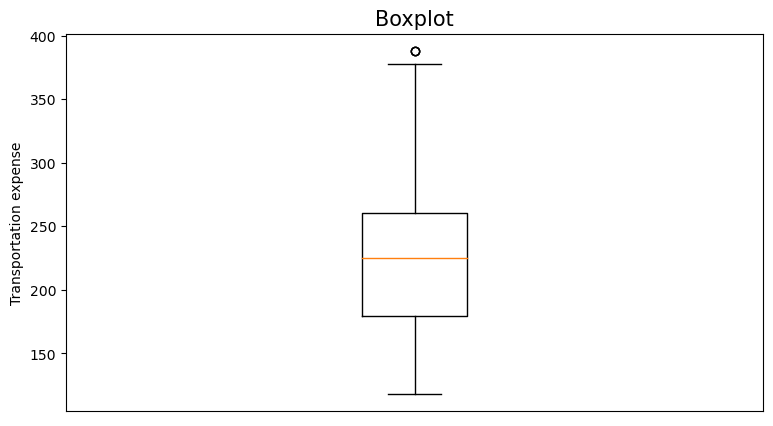

In [22]:
plt.figure(figsize=(9,5), dpi=100)
plt.boxplot(x = absent['Transportation_expense'])
plt.title('Boxplot', fontsize = 15)
plt.ylabel('Transportation expense')
plt.xticks([])
plt.show()

* p_val is greater than alpha (0.05) at 95% confidence level
* Z-score is greater than Z-critical, Z-score falls in acceptance region of H0
* Confidence interval does not contain the hypothesized mean 
* Therefore we fail to reject the null hypothesis and conclude that the average transport expense of employees is greater than 200

## Kruskal Wallis H test

<table align="left">
    <tr>
        <td width="6%">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>2. The HR department of the company wants to check if the average absenteeism hours is different for different seasons.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [65]:
# 1 - Summer, 2 - Autumn, 3 - Winter, 4 - Spring

abstime_1 = absent[absent['Seasons'] == 1]['Absenteeism_time_hours']
abstime_2 = absent[absent['Seasons'] == 2]['Absenteeism_time_hours']
abstime_3 = absent[absent['Seasons'] == 3]['Absenteeism_time_hours']
abstime_4 = absent[absent['Seasons'] == 4]['Absenteeism_time_hours']

In [44]:
# perform Shapiro-Wilk test to test the normality
stat, p_value = stats.shapiro(absent['Absenteeism_time_hours'])

# print the test statistic and p-value
print('Test statistic:', stat)
print('p-value:', p_value)

Test statistic: 0.40077584981918335
p-value: 7.286752014489049e-44


From the above result, we can see that the p-value is less than 0.05, thus we can say that the absenteeism time is not normally distributed. This does not satisfy the assumption of normality for ANOVA.

Thus we can not apply one-way ANOVA to test the equality of average absenteeism hours. We need to use the non-parametric equivalent Kruskal-Wallis H test

In [43]:
# perform Levene's test for the equality of variances 
stat, p_value = stats.levene(abstime_1, abstime_2, abstime_3, abstime_4)

# print the test statistic and p-value
print('Test statistic:', stat)
print('p-value:', p_value)

Test statistic: 1.0317681713491622
p-value: 0.37782075299767054


From the above result, we can see that the p-value is greater than 0.05, thus we can say that the population variances are equal for all the different seasons.

In [41]:
# H0 : The average absenteeism hours is the same across all seasons
# Ha : The average absenteeism hours is different across seasons

# obtain number of unique types of seasons
t = absent['Seasons'].nunique()
print('t:', t)

# unique seasons in the data
print('Unique seasons in the data:', sorted(absent['Seasons'].unique()))

# calculate the χ2-value for 95% of confidence level
# use 'stats.chi2.isf()' to find the χ2-value corresponding to the upper tail probability 'q'
chi2_val = np.abs(round(stats.chi2.isf(q = 0.05, df = t-1), 4))

print('\nCritical value for chi-square test:', chi2_val)

t: 4
Unique seasons in the data: [1, 2, 3, 4]

Critical value for chi-square test: 7.8147


In [66]:
# perform kruskal-wallis H test
test_stat, p_val = stats.kruskal(abstime_1, abstime_2, abstime_3, abstime_4)

# print the test statistic and corresponding p-value
print('Test statistic:', test_stat)
print('p-value:', p_val)

Test statistic: 7.379434123701476
p-value: 0.06073858686061599


* p_val is greater than alpha (0.05) at 95% confidence level
* Test statistic is lesser than Chi-critical (7.8147), Test statistic falls in acceptance region of H0
* Therefore we fail to reject the null hypothesis and conclude that the average absenteeism hours among employees is same across all the seasons

## Mann-Whitney U test

<table align="left">
    <tr>
        <td width="6%">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>3. The HR department of the company wants to check if the distribution of sum of absenteeism hours for smokers is different than the distribution of sum of absenteeism hours for non-smokers.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [1]:
# H0 : F_smokers = F_non-smokers (Sum of absenteeism hours among smokers and non-smokers are the same)
# Ha : F_smokers != F_non-smokers (Sum of absenteeism hours among smokers and non-smokers are different)

In [84]:
# Sum of absenteeism hours among smokers
abstime_sum_smoker = absent[absent['Social_smoker'] == 1].groupby('ID').Absenteeism_time_hours.sum()
print("Total of absenteeism hours among smokers:") 
print(abstime_sum_smoker)
print("\nNumber of smokers:", len(abstime_sum_smoker))

# perform Shapiro-Wilk test to test the normality
stat, p_value = shapiro(abstime_sum_smoker)

# print the corresponding p-value 
print('\np-value:', p_value)

Total of absenteeism hours among smokers:
ID
2      25
7      30
16     16
17    126
23     40
26     83
30     31
Name: Absenteeism_time_hours, dtype: int64

Number of smokers: 7

p-value: 0.04678918793797493


From the above result, we can see that the p-value is lesser than 0.05, thus we can say that the sum of absenteeism hours for smokers are not normally distributed.

In [81]:
# Sum of absenteeism hours among non-smokers
abstime_sum_nonsmoker = absent[absent['Social_smoker'] == 0].groupby('ID').Absenteeism_time_hours.sum()
print("Total of absenteeism hours among non-smokers:")
print(abstime_sum_nonsmoker)
print("\nNumber of non-smokers:", len(abstime_sum_nonsmoker))

# perform Shapiro-Wilk test to test the normality
stat, p_value = shapiro(abstime_sum_nonsmoker)

# print the corresponding p-value 
print('\np-value:', p_value)

Total of absenteeism hours among non-smokers:
ID
1     121
3     482
4       0
5     104
6      72
8       0
9     262
10    186
11    450
12     34
13    183
14    476
15    253
18    118
19      6
20    306
21     16
22    253
24    254
25     42
27     27
28    347
29     21
31     16
32     16
33     73
34    344
35      0
36    311
Name: Absenteeism_time_hours, dtype: int64

Number of non-smokers: 29

p-value: 0.00296563608571887


From the above result, we can see that the p-value is lesser than 0.05, thus we can say that the sum of absenteeism hours for non-smokers are not normally distributed.

In [82]:
# compute test statistic and corresponding p-value for two-tailed test
test_stat, p_value = stats.mannwhitneyu(abstime_sum_smoker, abstime_sum_nonsmoker, alternative = 'two-sided')

# print the test statistic and corresponding p-value
print('Test statistic:', test_stat)
print('p-value:', p_value)

Test statistic: 70.5
p-value: 0.22235694262452077


* p_val is greater than alpha (0.05) at 95% confidence level
* Therefore we fail to reject the null hypothesis and conclude that the distribution of sum of absenteeism hours for smokers is the same as the distribution of sum of absenteeism for non-smokers

## One-way ANOVA - Weight vs. number_children

<table align="left">
    <tr>
        <td width="6%">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>4. A consulting company wants to study the equality of average weight of employees with different number of children.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [138]:
# H0: The average weights of employees with different number of children is the same
# H1: The average weights of employees with different number of children is different

# Sum of absenteeism hours among non-smokers
emp_wt = absent.groupby('ID').Weight.unique().apply(lambda x: sum(x))

# perform Shapiro-Wilk test to test the normality
stat, p_value = shapiro(emp_wt)

# print the corresponding p-value 
print('\np-value:', p_value)


p-value: 0.22908827662467957


From the above result, we can see that the p-value is greater than 0.05, thus we can say that the weight of employees is normally distributed.

In [139]:
wt_zero = absent[absent['No_of_Children'] == 0].groupby('ID').Weight.unique().apply(lambda x: sum(x))
wt_one = absent[absent['No_of_Children'] == 1].groupby('ID').Weight.unique().apply(lambda x: sum(x))
wt_two = absent[absent['No_of_Children'] == 2].groupby('ID').Weight.unique().apply(lambda x: sum(x))
wt_three = absent[absent['No_of_Children'] == 3].groupby('ID').Weight.unique().apply(lambda x: sum(x))
wt_four = absent[absent['No_of_Children'] == 4].groupby('ID').Weight.unique().apply(lambda x: sum(x))

In [140]:
# perform Levene's test for the equality of variances 
stat, p_value = stats.levene(wt_zero, wt_one, wt_two, wt_three, wt_four)

# print the p-value 
print('p-value:', p_value)

p-value: 0.4335248705454786


From the above result, we can see that the p-value is greater than 0.05, thus we can say that the population variances are equal for the different groups.

* Assumption of normality is satisfied by Shapiro-Wilk test
* Assumption of equality of variance is satisfied by Levene's test

In [141]:
# obtain count of unique categories under number of children
t = absent['No_of_Children'].nunique()
print('t:', t)

# count of total number of employees
N = absent['ID'].nunique()
print('N:', N)

t: 5
N: 36


In [142]:
# calculate the F-value for 95% of confidence level
# use 'stats.f.isf()' to find the F-value corresponding to the upper tail probability 'q'

f = np.abs(round(stats.f.isf(q = 0.05, dfn = t-1, dfd = N-t), 4))

print('Critical value for F-test:', f)

Critical value for F-test: 2.6787


In [143]:
# perform one-way ANOVA
# pass the given data
f_test, p_val = stats.f_oneway(wt_zero, wt_one, wt_two, wt_three, wt_four)

# print the test statistic and corresponding p-value
print('Test statistic:', f_test)
print('p-value:', p_val)

Test statistic: 0.8962251490577251
p-value: 0.47802251612924485


* p_val is greater than alpha (0.05) at 95% confidence level
* Test statistic falls in acceptance region of H0
* Therefore we fail to reject the null hypothesis and conclude that the average weights of employees with different number of children are equal

## Chi-square goodness of fit

<table align="left">
    <tr>
        <td width="6%">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>5. The HR department claims that the 50% employees have completed high school (Education = 1), 25% employees are graduates (Education = 2), 20% employees are postgraduates (Education = 3) and 5% employees are doctorates (Education = 4).</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [43]:
# H0 : The observed number of employees from different education backgrounds is same as the claims made by HR
# Ha : The observed number of employees from different education backgrounds is different from the claims made by HR

absent.groupby('ID')['Education'].unique().apply(lambda x: sum(x)).value_counts()

1    28
2     4
3     3
4     1
Name: Education, dtype: int64

In [44]:
#### n = absent['ID'].nunique()
print("Number of employees:", n)

observed_values = np.array(absent.groupby('ID')['Education'].unique().apply(lambda x: sum(x)).value_counts())
print("Observed values:", observed_values)

expected_values = np.array(([n*0.5, n*0.25, n*0.2, n*0.05]))
print("Expected values:", expected_values)

# use the 'chisquare()' to perform the goodness of fit test
test_stat, p_value = stats.chisquare(f_obs = observed_values, f_exp = expected_values)

print('\nTest statistic:', round(test_stat, 5))
print('p-value:', round(p_value, 9))

Number of employees: 36
Observed values: [28  4  3  1]
Expected values: [18.   9.   7.2  1.8]

Test statistic: 11.13889
p-value: 0.010998076


In [54]:
# calculate the χ2-value for 90% of confidence level
chi2_val = np.abs(round(stats.chi2.isf(q = 0.05, df = 4-1), 4))

print('Critical value for chi-square test:', chi2_val)

Critical value for chi-square test: 7.8147


* p-value is lesser than alpha (0.05)
* Test statistic is greater than Chi-critical and falls in rejection region of H0
* Therefore we reject the null hypothesis and conclude that the number of employees from different education backgrounds is different from the claims made by HR

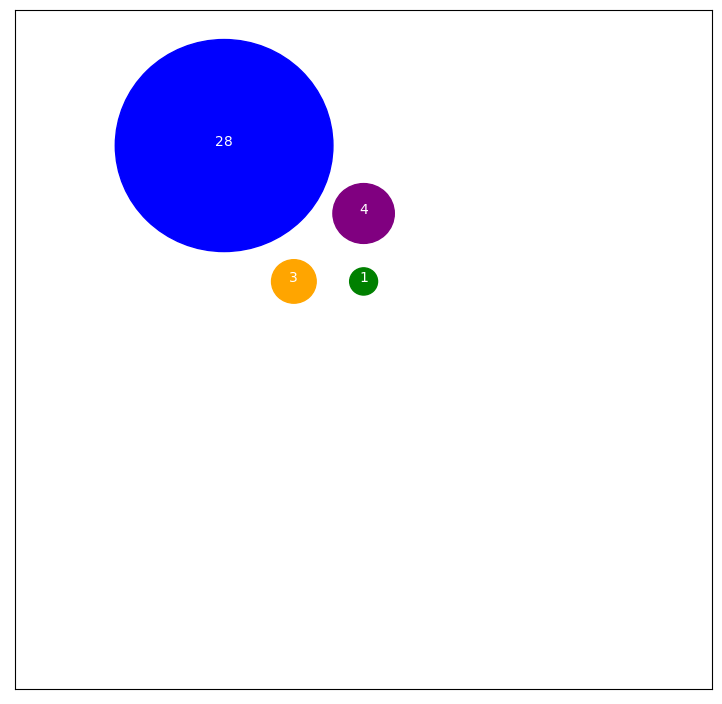

In [116]:
plt.figure(figsize=(9,9), dpi=100)
circle1 = plt.Circle(xy = (1.5,4), radius = 0.78, color = 'blue')
label = plt.text(x = 1.5, y = 4, s = "28", fontsize=10, ha="center", color = 'white')
circle2 = plt.Circle(xy = (2.5,3.5), radius = 0.22, color = 'purple')
label = plt.text(x = 2.5, y = 3.5, s = "4", fontsize=10, ha="center", color = 'white')
circle3 = plt.Circle(xy = (2,3), radius = 0.16, color = 'orange')
label = plt.text(x = 2, y = 3, s = "3", fontsize=10, ha="center", color = 'white')
circle4 = plt.Circle(xy = (2.5,3), radius = 0.1, color = 'green')
label = plt.text(x = 2.5, y = 3, s = "1", fontsize=10, ha="center", color = 'white')
ax = plt.gca()
ax.set_xlim((0, 5))
ax.set_ylim((0, 5))
plt.xticks([])
plt.yticks([])
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
plt.show()

## Chi-square test for independence

<table align="left">
    <tr>
        <td width="6%">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>6. A consulting company wants to check if there is any relationship between reason for absence and day of the week.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [23]:
# H0 : Reason for absence is independent of day of the week
# H1 : Reason for absence is dependent on day of the week

# use 'crosstab()' to create a table for each job role level and business travel count 
table = pd.crosstab(absent['Reason_for_absence'], absent['Day_of_the_week'])
print(table)

# observed values  
observed_values = table.values
observed_values

Day_of_the_week      2   3   4   5   6
Reason_for_absence                    
0                    5  13  11   7   6
1                    6   3   6   0   1
2                    0   0   1   0   0
3                    0   0   1   0   0
4                    0   0   0   2   0
5                    0   1   1   0   1
6                    2   2   2   1   1
7                    7   1   5   1   1
8                    1   2   1   1   1
9                    1   2   1   0   0
10                   9   1   6   4   5
11                  10   4   7   4   1
12                   2   2   2   1   1
13                  12  10  14  12   7
14                   3   4   1   7   4
15                   1   0   0   0   1
16                   0   2   0   0   1
17                   0   1   0   0   0
18                   5   8   4   2   2
19                  11   9   5   8   7
21                   1   1   2   2   0
22                   9   6   9   4  10
23                  22  37  33  30  27
24                   1   

array([[ 5, 13, 11,  7,  6],
       [ 6,  3,  6,  0,  1],
       [ 0,  0,  1,  0,  0],
       [ 0,  0,  1,  0,  0],
       [ 0,  0,  0,  2,  0],
       [ 0,  1,  1,  0,  1],
       [ 2,  2,  2,  1,  1],
       [ 7,  1,  5,  1,  1],
       [ 1,  2,  1,  1,  1],
       [ 1,  2,  1,  0,  0],
       [ 9,  1,  6,  4,  5],
       [10,  4,  7,  4,  1],
       [ 2,  2,  2,  1,  1],
       [12, 10, 14, 12,  7],
       [ 3,  4,  1,  7,  4],
       [ 1,  0,  0,  0,  1],
       [ 0,  2,  0,  0,  1],
       [ 0,  1,  0,  0,  0],
       [ 5,  8,  4,  2,  2],
       [11,  9,  5,  8,  7],
       [ 1,  1,  2,  2,  0],
       [ 9,  6,  9,  4, 10],
       [22, 37, 33, 30, 27],
       [ 1,  1,  1,  0,  0],
       [10,  5,  3,  8,  5],
       [10,  6,  7,  2,  8],
       [10,  7, 20, 12, 20],
       [22, 26, 13, 17, 34]], dtype=int64)

In [22]:
# calculate the χ2-value for 99% of confidence level
# use 'stats.chi2.isf()' to find the χ2-value corresponding to the upper tail probability 'q'

# df = (r - 1) * (c - 1)
# df = 27 * 4 = 108

chi2_val = np.abs(round(stats.chi2.isf(q = 0.05, df = 108), 4))

print('Critical value for chi-square test:', chi2_val)

Critical value for chi-square test: 133.2569


In [24]:
# use the 'chi2_contingency()' to check the independence of variables

test_stat, p, dof, expected_value = stats.chi2_contingency(observed = observed_values, correction = False)

print("Test statistic:", round(test_stat, 7))
print("p-value:", round(p, 6))
print("Degrees of freedom:", dof)
print("\nExpected values:") 
print(expected_value)

Test statistic: 132.9140038
p-value: 0.05213
Degrees of freedom: 108

Expected values:
[[ 9.09336942  8.75236806  8.86603518  7.10419486  8.18403248]
 [ 3.46414073  3.33423545  3.37753721  2.70635995  3.11772666]
 [ 0.2165088   0.20838972  0.21109608  0.1691475   0.19485792]
 [ 0.2165088   0.20838972  0.21109608  0.1691475   0.19485792]
 [ 0.43301759  0.41677943  0.42219215  0.33829499  0.38971583]
 [ 0.64952639  0.62516915  0.63328823  0.50744249  0.58457375]
 [ 1.73207037  1.66711773  1.68876861  1.35317997  1.55886333]
 [ 3.24763194  3.12584574  3.16644114  2.53721245  2.92286874]
 [ 1.29905277  1.25033829  1.26657645  1.01488498  1.1691475 ]
 [ 0.86603518  0.83355886  0.8443843   0.67658999  0.77943166]
 [ 5.41271989  5.2097429   5.27740189  4.22868742  4.8714479 ]
 [ 5.62922869  5.41813261  5.48849797  4.39783491  5.06630582]
 [ 1.73207037  1.66711773  1.68876861  1.35317997  1.55886333]
 [11.90798376 11.46143437 11.61028417  9.30311231 10.71718539]
 [ 4.11366712  3.9594046   4.01

* p-value is just slightly greater than alpha (0.05)
* Test statistic is lesser than Chi-critical value and falls in acceptance region of H0
* Therefore we fail to reject the null hypothesis and conclude that reason for absence is independent of day of the week**

## Wilcoxon Rank Sum test

<table align="left">
    <tr>
        <td width="6%">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>7. A consulting company wants to check if there is any difference in medians of absenteeism hours for social drinkers and non-drinkers.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [27]:
# H0 : Median absenteeism hours of social drinkers and non-drinkers are same
# Ha : Median absenteeism hours of social drinkers and non-drinkers are different

# calculate the z-value for 95% of confidence level
z_val = np.abs(round(stats.norm.isf(q = 0.05/2), 2))

print('Critical value for two-tailed Z-test:', z_val)

Critical value for two-tailed Z-test: 1.96


In [28]:
abstime_nondrinker = absent[absent['Social_drinker'] == 0]['Absenteeism_time_hours']
abstime_drinker = absent[absent['Social_drinker'] == 1]['Absenteeism_time_hours']

test_stat, p_value = stats.ranksums(abstime_drinker, abstime_nondrinker)
print("Test statistic:", round(test_stat, 5))
print("p-value:", round(p_value, 9))

Test statistic: 2.74685
p-value: 0.006017126


* p-value is less than alpha (0.05)
* Test statistic is greater than Z-critical (1.96) and it falls in rejection region of H0
* Therefore, we reject the null hypothesis and conclude there is difference in medians of absenteeism hours among social drinkers and non-drinkers 

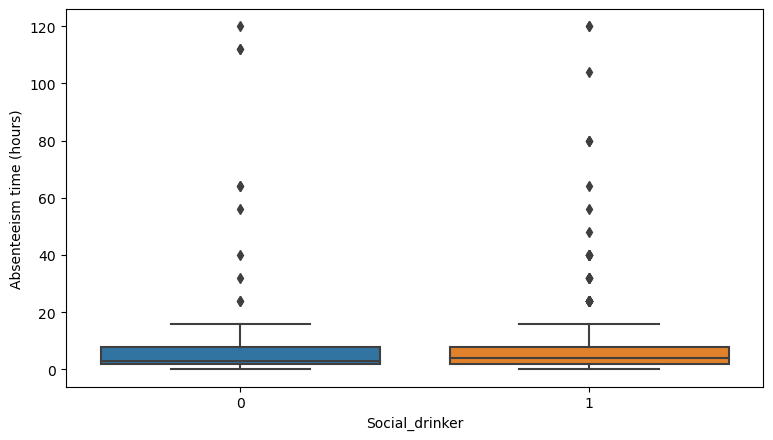

In [42]:
plt.figure(figsize=(9,5), dpi=100)
sns.boxplot(x = absent['Social_drinker'], 
            y = absent['Absenteeism_time_hours'],
            orient = "v")
plt.ylabel('Absenteeism time (hours)')
plt.show()

## CLT Simulation of Absenteeism time 

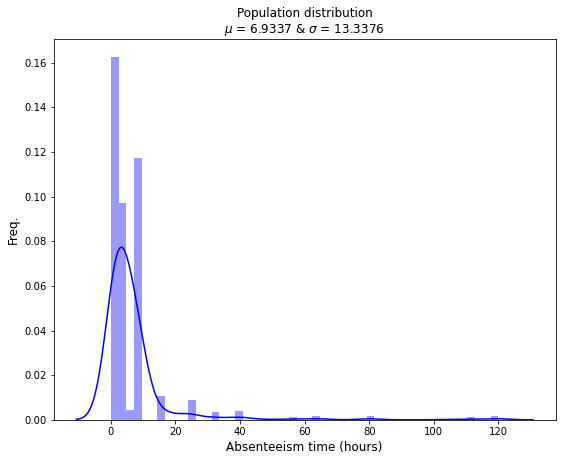

In [59]:
plt.figure(figsize = (9, 7))
sns.distplot(absent['Absenteeism_time_hours'], color = 'blue')
mu = absent['Absenteeism_time_hours'].mean()
sigma = absent['Absenteeism_time_hours'].std()
plt.title("Population distribution\n$\mu$ = %.4f & $\sigma$ = %.4f" % (mu, sigma))
plt.ylabel('Freq.', fontsize = 12)
plt.xlabel('Absenteeism time (hours)', fontsize = 12)
plt.show()

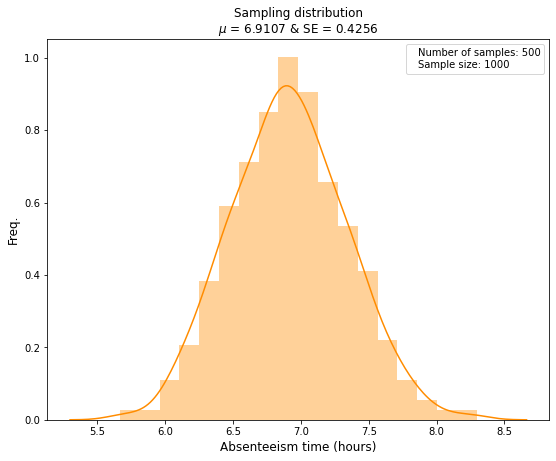

In [61]:
# Simulation of Absenteeism time (hours)

number_of_sample = 500
sample_size = 1000

df500 = pd.DataFrame()

for i in range(1, number_of_sample+1):
    normal_sample = np.random.normal(loc = mu, scale = sigma, size = sample_size)
    col = f'Sample_{i}'
    df500[col] = normal_sample
    
# Plotting the sampling distribution
df_absenteeism_sample_means = pd.DataFrame(df500.mean(), columns = ['Sample_Means'])


plt.figure(figsize = (9, 7))
sns.distplot(df_absenteeism_sample_means, color = 'darkorange')
xbar = df_absenteeism_sample_means['Sample_Means'].mean()
SE = df_absenteeism_sample_means['Sample_Means'].std()
plt.title("Sampling distribution\n$\mu$ = %.4f & SE = %.4f" % (xbar, SE))
plt.legend(['Number of samples: %d\nSample size: %d' % (number_of_sample, sample_size)], handlelength=0)
plt.ylabel('Freq.', fontsize = 12)
plt.xlabel('Absenteeism time (hours)', fontsize = 12)
plt.show()

In [48]:
df500

,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10,...,Sample_491,Sample_492,Sample_493,Sample_494,Sample_495,Sample_496,Sample_497,Sample_498,Sample_499,Sample_500
0,-16.139066,6.728833,-2.494037,23.635990,-11.538505,3.832489,-9.763650,1.959997,-15.463620,21.768849,...,-3.914468,-9.254634,24.754786,6.975374,7.268947,0.920033,6.374920,-5.980468,-8.980728,-16.280839
1,25.448047,19.337303,21.508415,9.620630,20.598964,1.612801,-11.851344,25.625837,-8.960519,1.728561,...,-2.304623,3.813681,34.499700,12.954012,-4.374760,-13.355192,22.547168,6.794343,7.843246,15.710863
2,13.585760,0.172898,15.677808,13.219104,5.542606,2.651442,18.606327,-6.527411,4.056884,22.294198,...,13.843119,-1.421962,12.742190,23.691456,26.334157,9.782888,14.854822,-5.804578,6.216379,34.650198
3,10.775075,1.647186,-8.650587,-11.916028,9.158382,16.400570,12.619845,6.919026,-0.965978,9.816054,...,12.845302,4.363031,14.468747,34.765632,35.808134,15.048218,28.900804,-7.441358,-11.858530,14.670389
4,-6.760873,22.012182,33.298232,23.568805,32.674028,-2.399156,27.084806,6.623454,25.772927,-7.065315,...,-16.598622,-11.619569,2.993537,-18.164722,9.763253,-0.515314,13.198739,20.477720,19.548602,-9.752459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,17.707583,4.727857,32.105811,19.600962,4.948897,-6.041978,4.421426,10.313261,6.111684,6.436548,...,27.612091,-9.755531,-6.709051,9.309210,0.130803,10.156606,-12.564230,-15.518254,-5.717470,12.803121
996,23.917443,24.971981,4.251343,-14.170737,12.490826,21.477978,-3.347635,4.491376,0.079160,23.478512,...,17.103707,10.983736,7.073011,12.722370,15.899241,28.790592,-8.365495,14.302962,18.585622,7.758792
997,5.170038,-27.273194,27.711120,-9.570659,-1.567656,-2.568007,25.915789,6.038277,-11.183797,7.005927,...,13.565462,-2.972409,-3.968904,7.515177,2.084750,17.498387,-7.547584,17.868446,-5.391384,11.766543
998,29.455908,8.104574,5.594539,1.952610,-8.909407,3.683961,11.855156,-13.732758,-8.865303,13.349624,...,-0.974792,9.853366,0.473133,15.502126,22.400724,14.652107,21.006365,-6.555682,-8.428681,9.519564


In [49]:
df_absenteeism_sample_means

,Sample_Means
Sample_1,6.596846
Sample_2,6.788536
Sample_3,7.361932
Sample_4,7.688025
Sample_5,6.924656
...,...
Sample_496,6.259948
Sample_497,6.475338
Sample_498,6.808419
Sample_499,7.100080


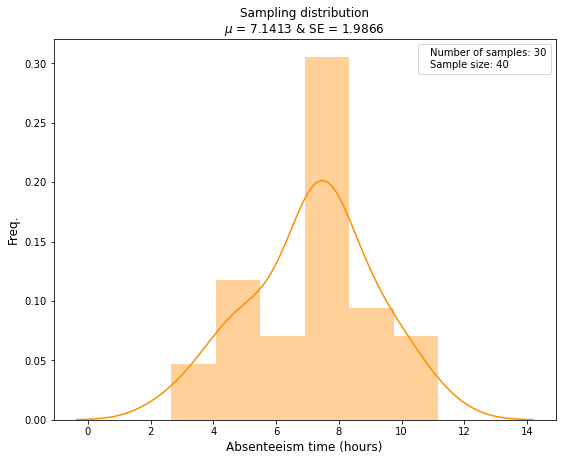

In [64]:
# Simulation of Absenteeism time (hours)

number_of_sample = 30
sample_size = 40

df500 = pd.DataFrame()

for i in range(1, number_of_sample+1):
    normal_sample = np.random.normal(loc = mu, scale = sigma, size = sample_size)
    col = f'Sample_{i}'
    df500[col] = normal_sample
    
# Plotting the sampling distribution
df_absenteeism_sample_means = pd.DataFrame(df500.mean(), columns = ['Sample_Means'])


plt.figure(figsize = (9, 7))
sns.distplot(df_absenteeism_sample_means, color = 'darkorange')
xbar = df_absenteeism_sample_means['Sample_Means'].mean()
SE = df_absenteeism_sample_means['Sample_Means'].std()
plt.title("Sampling distribution\n$\mu$ = %.4f & SE = %.4f" % (xbar, SE))
plt.legend(['Number of samples: %d\nSample size: %d' % (number_of_sample, sample_size)], handlelength=0)
plt.ylabel('Freq.', fontsize = 12)
plt.xlabel('Absenteeism time (hours)', fontsize = 12)
plt.show()